In [ ]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu
pip check

# Additional callbacks

In this reading we'll be looking at more of the inbuilt callbacks available in Keras.

In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.get_logger().setLevel('ERROR')

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

We will again be using the sklearn diabetes dataset to demonstrate these callbacks.

In [3]:
# Load the diabetes dataset
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [5]:
# Split the data set into training and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)
print(f"Train data shape: {train_data.shape}")

Train data shape: (397, 10)


Let's also build a simple model to fit the data with our callbacks.

In [7]:
def get_model(input_shape):
    """
    Build a sequential model.
    """
    
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=128, activation='relu', 
            input_shape=input_shape),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    # Compile the model
    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=tf.keras.optimizers.Adam(), 
        metrics=[tf.keras.metrics.MeanSquaredError(), 
            tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# Print the model summary
model = get_model(input_shape=(train_data.shape[1],))
print(model.summary())
print(model.loss)
print(model.optimizer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1408      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,049
Trainable params: 18,049
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
class PlotHistory():
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)
    
    def __init__(self, history, metrics=['loss']):
        super().__init__()
        self.history = history
        self.metrics = metrics
        
    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows,
            ncols=cls.plt_ncols, figsize=cls.plt_figsize)
    
    def plot(self):
        df_history = pd.DataFrame(self.history.history,
            index=self.history.epoch)
        fig, axes = self._create_plot()
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(ax=ax, data=df_history,
                x=df_history.index+1, y=metric, label='train')
            try:
                sns.lineplot(ax=ax, data=df_history,
                    x=df_history.index+1, y=f'val_{metric}',
                    label='valid')
            except Exception:
                pass
            ax.legend(loc='best')
            ax.set_xlabel('epoch')
            ax.set_ylabel(f'{metric}')
            ax.set_title(f'{metric} vs. epoch')
        fig.tight_layout()
        plt.show()

Now onto the callbacks!

## Learning rate scheduler

**usage:** `tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)`

The learning rate scheduler that we implemented in the previous reading as a custom callback is also available as a built in callback.

As in our custom callback, the `LearningRateScheduler` in Keras takes a function `schedule` as an argument.

This function `schedule` should take two arguments:
* The current epoch (as an integer), and
* The current learning rate,

and return new learning rate for that epoch.

The `LearningRateScheduler` also has an optional `verbose` argument, which prints information about the learning rate if it is set to 1.

Let's see a simple example.

In [9]:
# Define the learning rate schedule function
def lr_function(epoch, lr):
    if epoch%2==0:
        return lr
    else:
        return lr+(epoch/1000.)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.

Epoch 2: LearningRateScheduler setting learning rate to 0.0020000000474974513.

Epoch 3: LearningRateScheduler setting learning rate to 0.0020000000949949026.

Epoch 4: LearningRateScheduler setting learning rate to 0.005000000094994903.

Epoch 5: LearningRateScheduler setting learning rate to 0.004999999888241291.

Epoch 6: LearningRateScheduler setting learning rate to 0.009999999888241292.

Epoch 7: LearningRateScheduler setting learning rate to 0.009999999776482582.

Epoch 8: LearningRateScheduler setting learning rate to 0.01699999977648258.

Epoch 9: LearningRateScheduler setting learning rate to 0.016999999061226845.

Epoch 10: LearningRateScheduler setting learning rate to 0.025999999061226846.


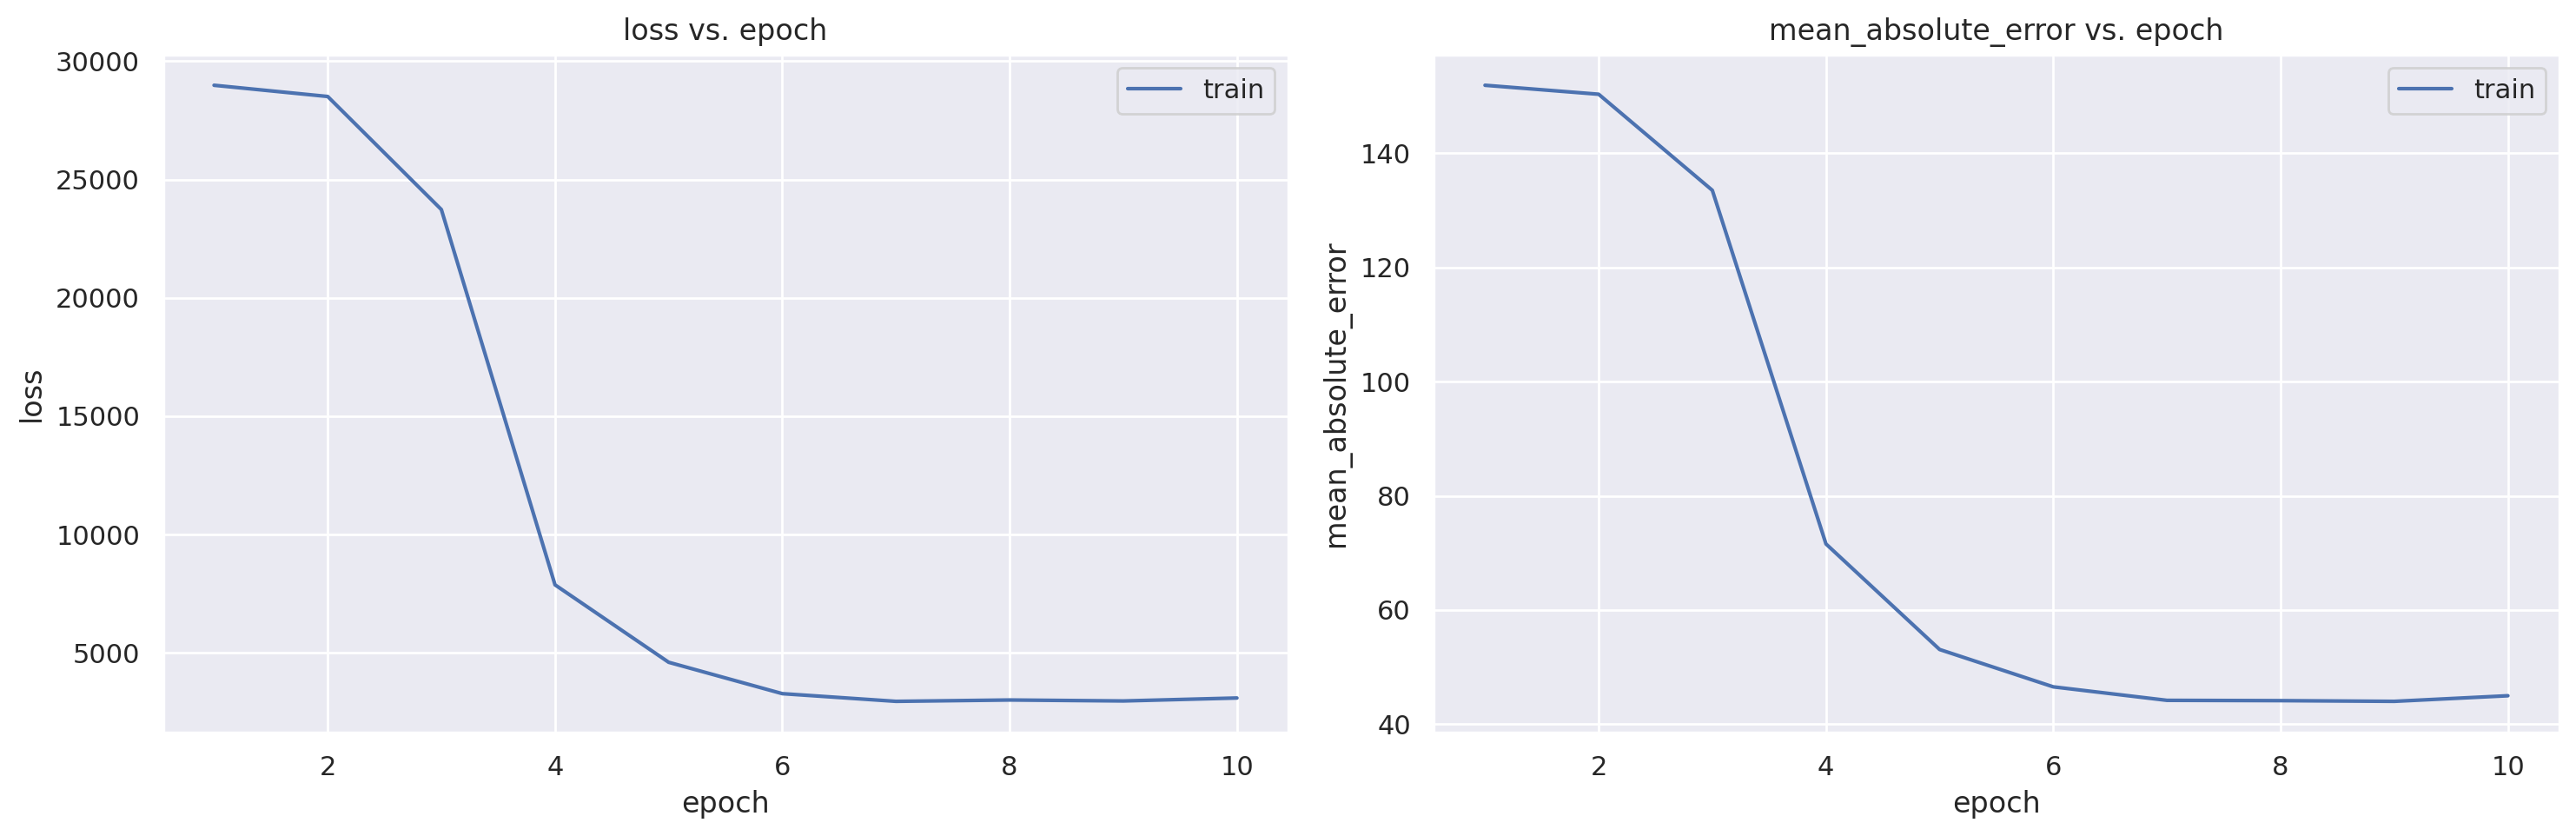

In [11]:
# Train the model
model = get_model(input_shape=(train_data.shape[1],))
history = model.fit(train_data, train_targets,
    epochs=10, verbose=0,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(
        lr_function, verbose=2)])

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

You can also use lambda functions to define your schedule given an epoch.


Epoch 1: LearningRateScheduler setting learning rate to 0.3333333333333333.

Epoch 2: LearningRateScheduler setting learning rate to 0.125.

Epoch 3: LearningRateScheduler setting learning rate to 0.07692307692307693.

Epoch 4: LearningRateScheduler setting learning rate to 0.05555555555555555.

Epoch 5: LearningRateScheduler setting learning rate to 0.043478260869565216.

Epoch 6: LearningRateScheduler setting learning rate to 0.03571428571428571.

Epoch 7: LearningRateScheduler setting learning rate to 0.030303030303030304.

Epoch 8: LearningRateScheduler setting learning rate to 0.02631578947368421.

Epoch 9: LearningRateScheduler setting learning rate to 0.023255813953488372.

Epoch 10: LearningRateScheduler setting learning rate to 0.020833333333333332.


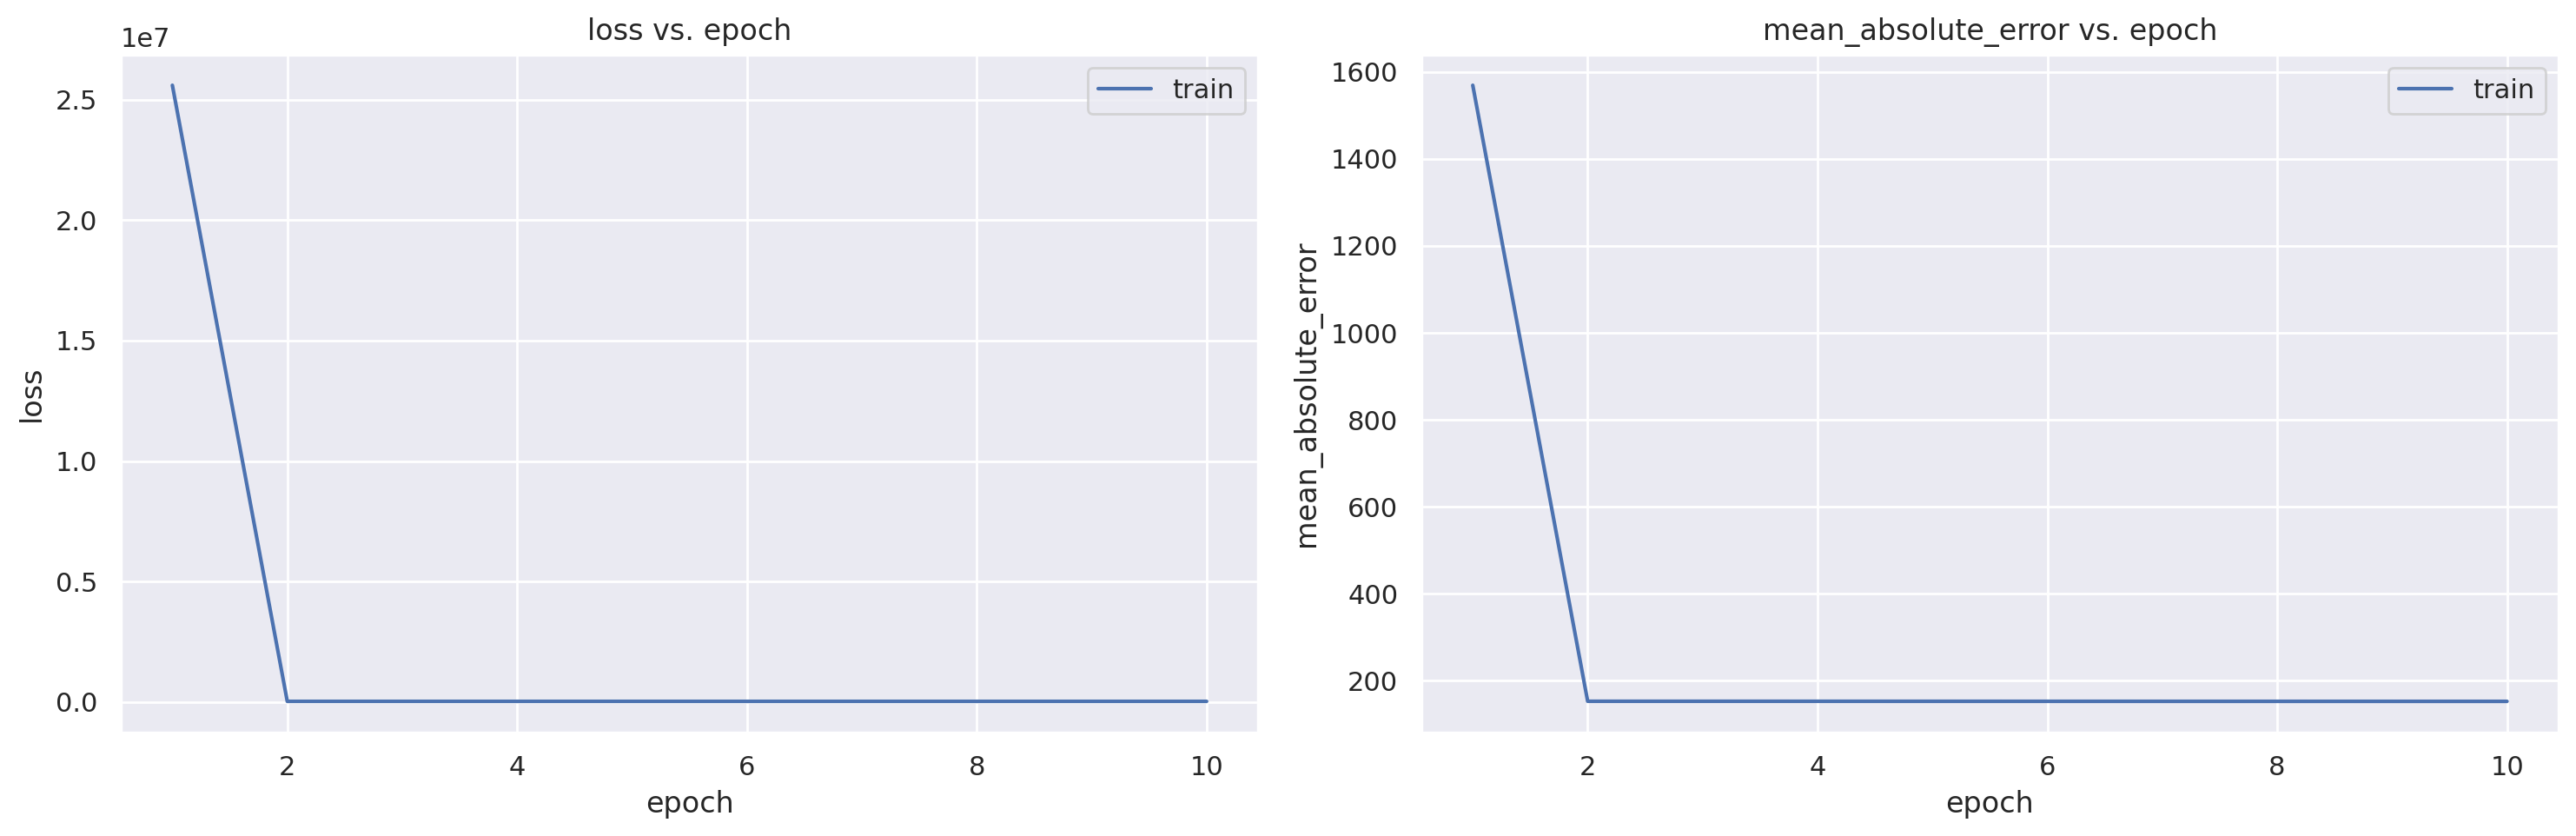

In [12]:
# Train the model with a difference schedule
model = get_model(input_shape=(train_data.shape[1],))
history = model.fit(train_data, train_targets,
    epochs=10, verbose=0,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(
        lambda x: 1/(3+5*x), verbose=2)])

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

## CSV logger
**Usage** `tf.keras.callbacks.CSVLogger(filename, separator=',', append=False)`

This callback streams the results from each epoch into a CSV file. The first line of the CSV file will be the name of pieces of information recorded on each subsequent line, begining with the epoch and loss value. The values of metrics at the end of each epoch will also be recorded.

The only compulsory argument is the `filename` for the log to be streamed to. This could also be a filepath.

You can also specify the `separator` to be used between entries on each line.

The `append` argument allows you the option to append your results to an existing file with the same name. This can be particularly useful if you are continuing training.

Let's see an example.

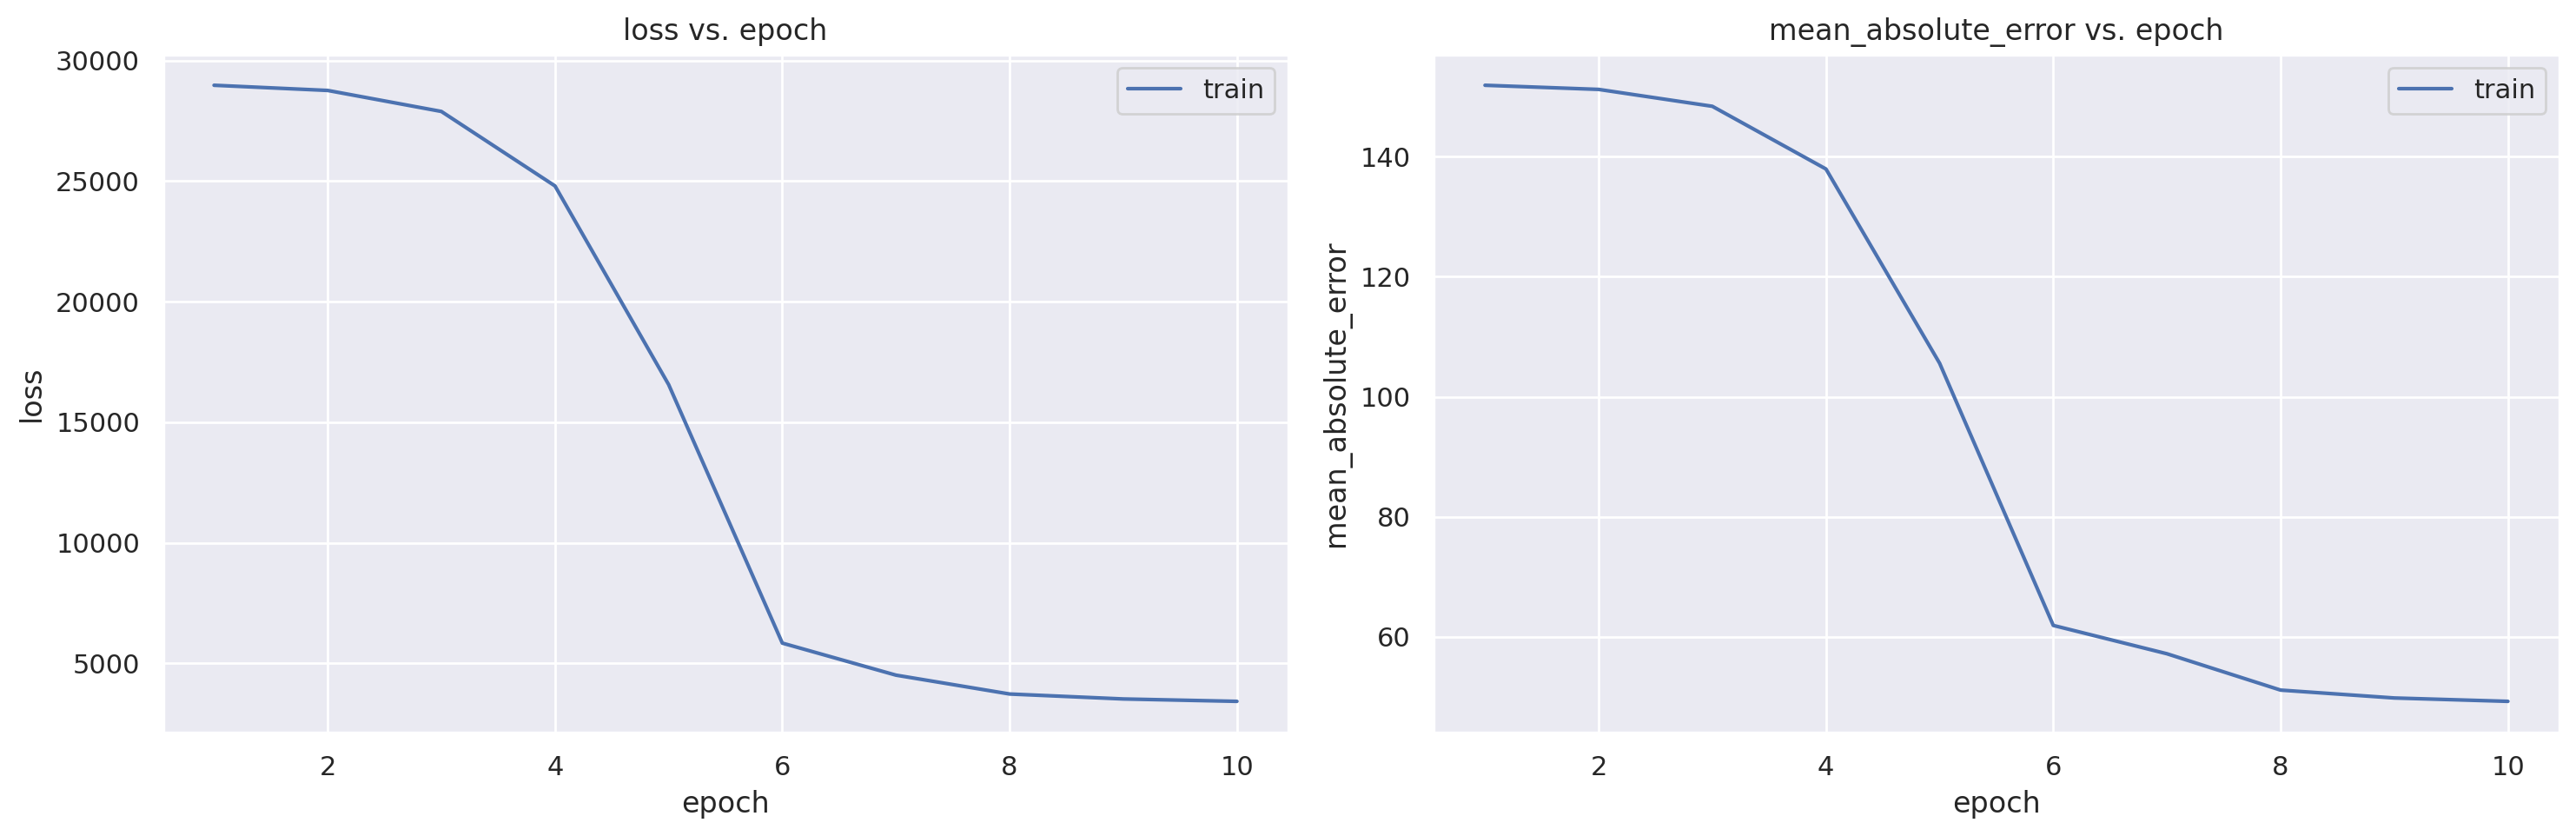

In [13]:
# Train the model with a CSV logger
model = get_model(input_shape=(train_data.shape[1],))
history = model.fit(train_data, train_targets,
    epochs=10, verbose=0,
    callbacks=[tf.keras.callbacks.CSVLogger("results.csv")])

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

Let's view the information in the CSV file we have created using `pandas`.

In [14]:
# Load the CSV
pd.read_csv("results.csv", index_col='epoch')

,loss,mean_absolute_error,mean_squared_error
epoch,,,
0,28978.781250,151.893936,28978.781250
1,28763.855469,151.203003,28763.855469
2,27892.640625,148.390869,27892.640625
3,24802.275391,137.942749,24802.275391
4,16560.699219,105.580643,16560.699219
5,5839.249512,61.909687,5839.249512
6,4510.305176,57.189831,4510.305176
7,3727.918457,51.135162,3727.918457
8,3522.335693,49.822601,3522.335693


In [1]:
! rm -rf results.csv

## Lambda callbacks
**Usage** `tf.keras.callbacks.LambdaCallback(                
        on_epoch_begin=None, on_epoch_end=None,                 
        on_batch_begin=None, on_batch_end=None,                 
        on_train_begin=None, on_train_end=None)`
    
Lambda callbacks are used to quickly define simple custom callbacks with the use of lambda functions.

Each of the functions require some positional arguments.
* `on_epoch_begin` and `on_epoch_end` expect two arguments: `epoch` and `logs`,
* `on_batch_begin` and `on_batch_end` expect two arguments: `batch` and `logs` and 
* `on_train_begin` and `on_train_end` expect one argument: `logs`.

Let's see an example of this in practice.

In [15]:
# Print the epoch number at the beginning of each epoch
epoch_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch, logs: print(
        'Starting Epoch {}!'.format(epoch+1)))

In [16]:
# Print the loss at the end of each batch
batch_loss_callback = tf.keras.callbacks.LambdaCallback(
    on_batch_end=lambda batch, logs: print(
        '\n After batch {}, the loss is {:7.2f}.'.format(
            batch, logs['loss'])))

In [17]:
# Inform that training is finished
train_finish_callback = tf.keras.callbacks.LambdaCallback(
    on_train_end=lambda logs: print(
        'Training finished'))

Starting Epoch 1!

 After batch 0, the loss is 32570.56.

 After batch 1, the loss is 27578.12.

 After batch 2, the loss is 28367.98.

 After batch 3, the loss is 29005.25.
Starting Epoch 2!

 After batch 0, the loss is 29916.63.

 After batch 1, the loss is 28833.96.

 After batch 2, the loss is 29209.72.

 After batch 3, the loss is 28977.36.
Starting Epoch 3!

 After batch 0, the loss is 28089.49.

 After batch 1, the loss is 28347.49.

 After batch 2, the loss is 28927.87.

 After batch 3, the loss is 28934.44.
Starting Epoch 4!

 After batch 0, the loss is 29952.78.

 After batch 1, the loss is 29530.64.

 After batch 2, the loss is 29339.01.

 After batch 3, the loss is 28870.18.
Starting Epoch 5!

 After batch 0, the loss is 32771.13.

 After batch 1, the loss is 30944.07.

 After batch 2, the loss is 28815.11.

 After batch 3, the loss is 28772.62.
Training finished


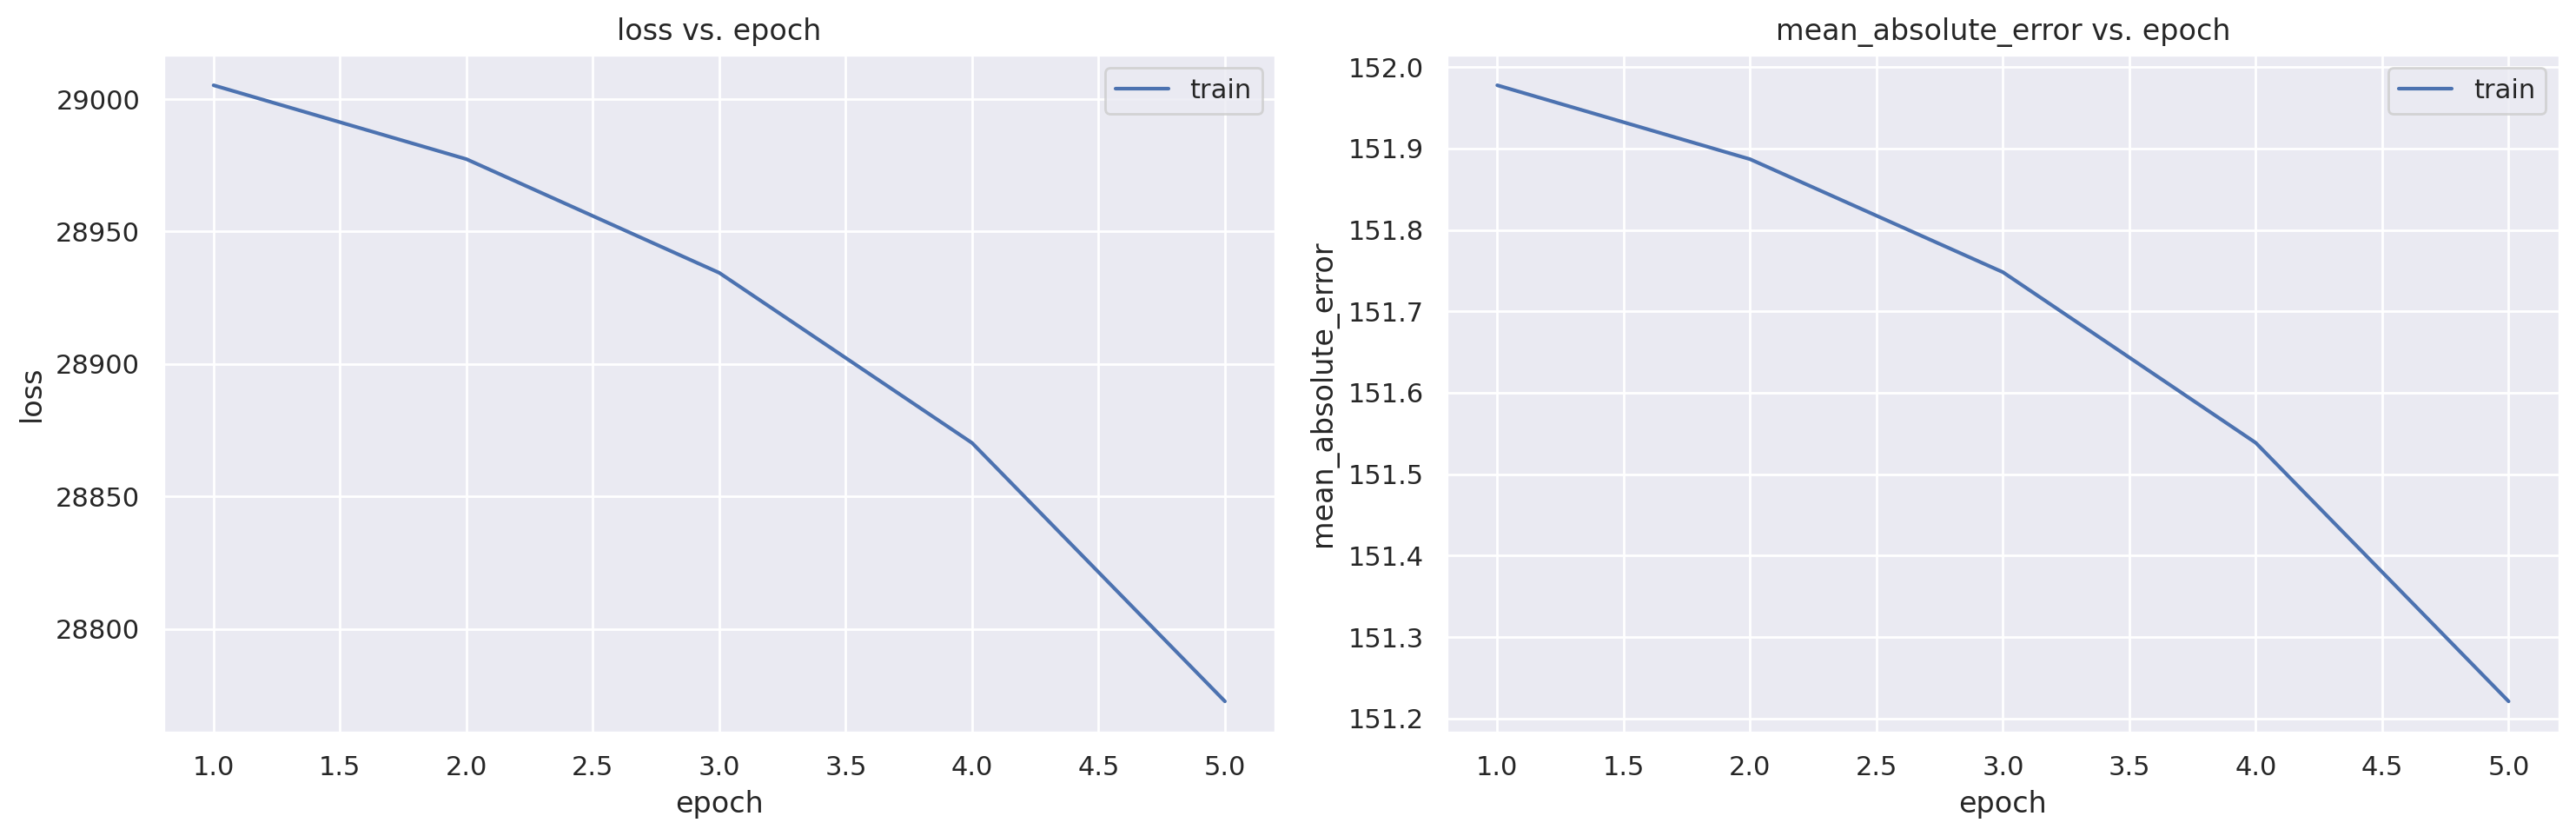

In [18]:
# Train the model with the lambda callbacks
model = get_model(input_shape=(train_data.shape[1],))
history = model.fit(train_data, train_targets,
    epochs=5, batch_size=100, verbose=0,
    callbacks=[epoch_callback, batch_loss_callback, train_finish_callback])

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

## Reduce learning rate on plateau
**Usage** `tf.keras.callbacks.ReduceLROnPlateau(                        
            monitor='val_loss', factor=0.1, patience=10, verbose=0,            
            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)` 
    
The `ReduceLROnPlateau` callback allows reduction of the learning rate when a metric has stopped improving.
The arguments are similar to those used in the `EarlyStopping` callback.
* The argument `monitor` is used to specify which metric to base the callback on.
* The `factor` is the factor by which the learning rate decreases i.e., new_lr=factor*old_lr.
* The `patience` is the number of epochs where there is no improvement on the monitored metric before the learning rate is reduced.
* The `verbose` argument will produce progress messages when set to 1.
* The `mode` determines whether the learning rate will decrease when the monitored quantity stops increasing (`max`) or decreasing (`min`). The `auto` setting causes the callback to infer the mode from the monitored quantity.
* The `min_delta` is the smallest change in the monitored quantity to be deemed an improvement.
* The `cooldown` is the number of epochs to wait after the learning rate is changed before the callback resumes normal operation.
* The `min_lr` is a lower bound on the learning rate that the callback will produce.

Let's examine a final example.

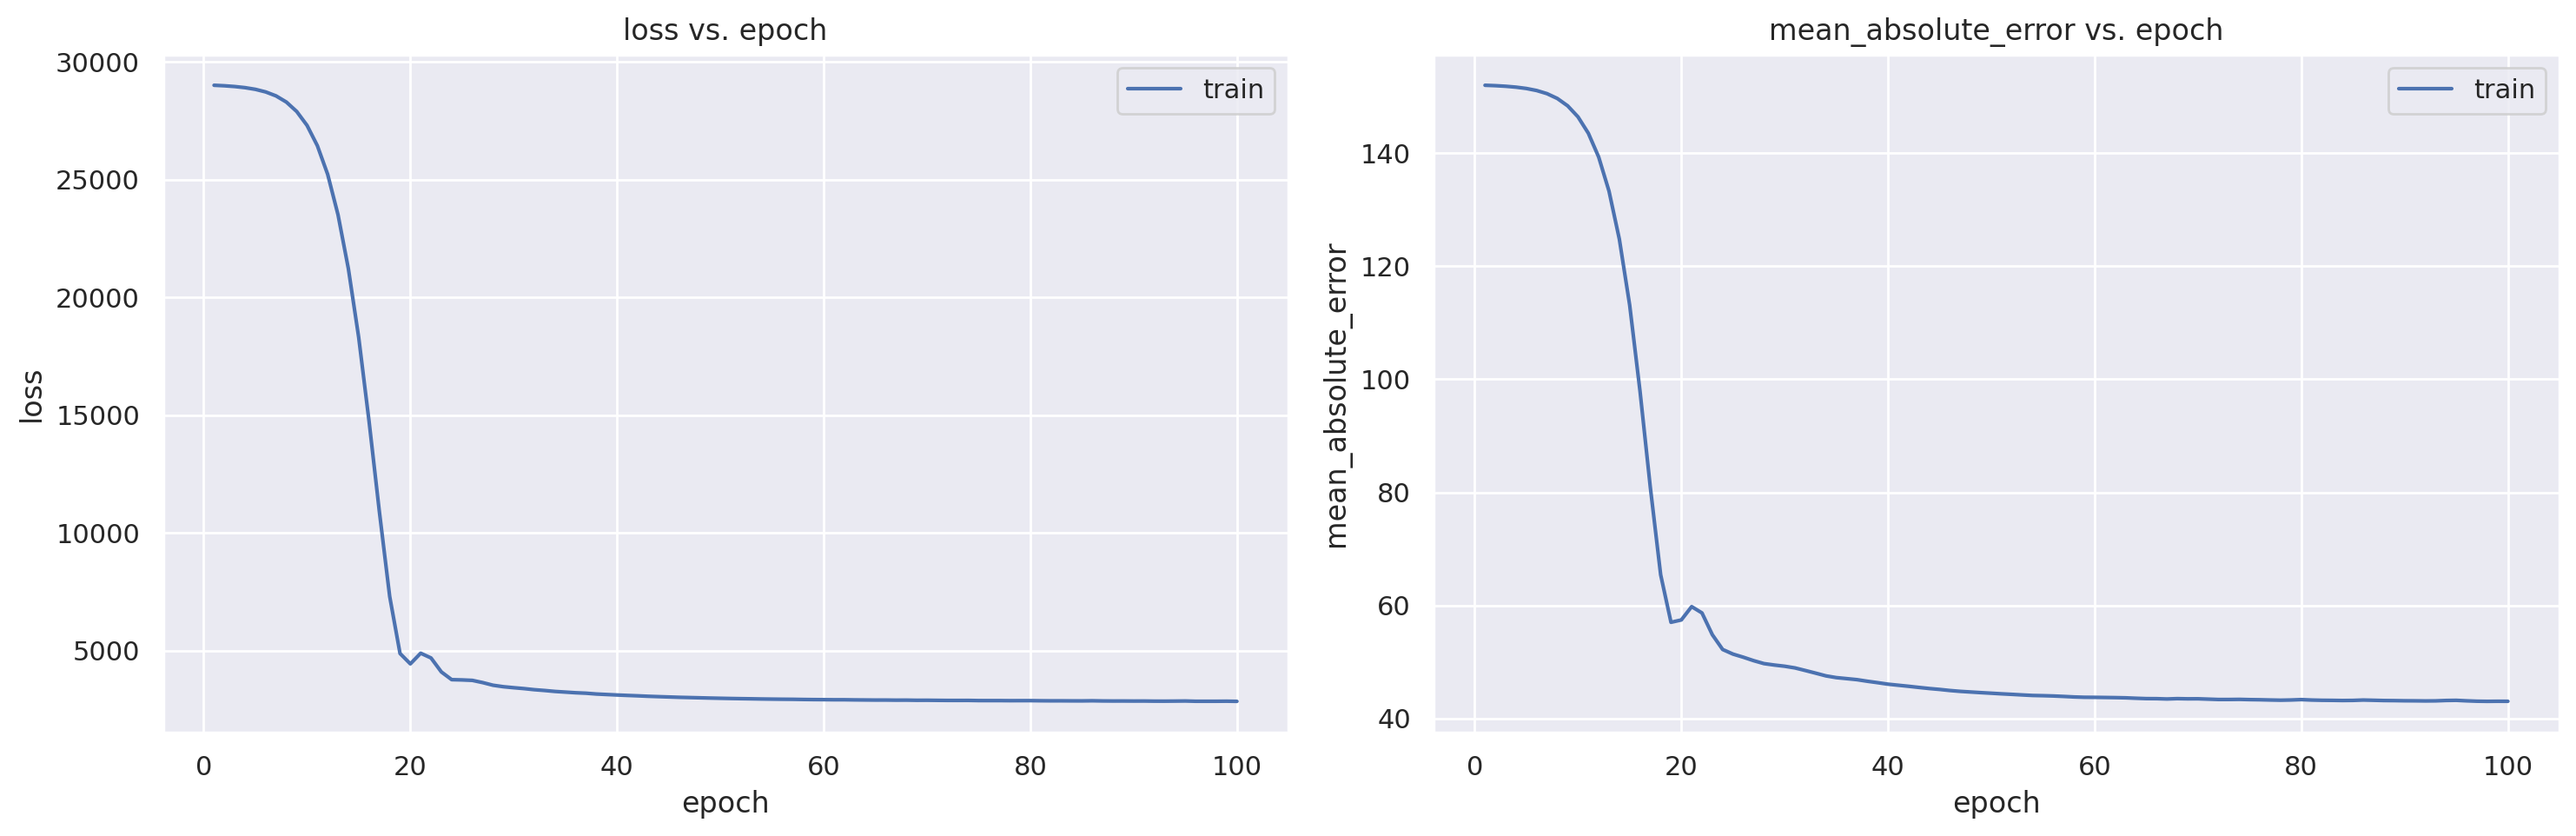

In [19]:
# Train the model with the ReduceLROnPlateau callback
model = get_model(input_shape=(train_data.shape[1],))
history = model.fit(train_data, train_targets,
    epochs=100, batch_size=100, verbose=0,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', factor=0.2, verbose=2)])

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

### Further reading and resources

* https://keras.io/callbacks/
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CSVLogger
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback